# Project Luther - Feature Engineering & Modeling

## Import Modules

In [111]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import matplotlib.pyplot as plt

import patsy
import scipy.stats as stats
import pylab

import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing


# sns.set_style("whitegrid", {"font.family": ["serif"]})
# sns.set_context("talk") 

import pickle

from datetime import datetime

import random 

%matplotlib inline

## Import Pickle

In [4]:
# Import df with all main scraped data
# This will be the source for all of the feature and modeling work below. 
with open('data_files/active_pickles/scrapedFilms_all.pickle','rb') as read_file:
    scrapedFilms_all = pickle.load(read_file)

In [6]:
# Number cleaning function
def dollars_to_int(dollars):
    try:
        dollars = dollars.replace('$', '')
    except:
        pass
    try:
        dollars = dollars.replace(',', '')
    except:
        pass
    if '.' in dollars:
        try:
            dollars = float(dollars)
        except:
            pass
    else:
        try: 
            dollars = int(dollars)
        except:
            pass
    return dollars

In [7]:
scrapedFilms_all

,title,titleID,MOVIEmeter_now,URL,Target,Budget,Opening,USGross,WWGross,IntlGross,...,Release_str,MOVIEmeter_launch,MMReleaseDate,Ratings,RatingsVotes,Articles,OpeningProp,NAGrossProp,IntlGrossProp,WorldGrossProp
0,The Upside,tt1987680,14,https://pro.imdb.com/title/tt1987680/,TARGET,37500000,20355000,46663439,50763439,4100000,...,2019-01-11,27,2019-01-13 00:00:00,5.8,6400,246,0.542800,1.244358,0.109333,1.353692
1,Split,tt4972582,18,https://pro.imdb.com/title/tt4972582/,TARGET,9000000,40010975,138291365,278454358,140162993,...,2017-01-20,5,2017-01-22 00:00:00,7.3,318839,1197,4.445664,15.365707,15.573666,30.939373
2,The Greatest Showman,tt1485796,109,https://pro.imdb.com/title/tt1485796/,TARGET,84000000,8805843,174340174,434993183,260653009,...,2017-12-20,8,2017-12-24 00:00:00,7.7,184604,1044,0.104831,2.075478,3.103012,5.178490
3,Spider-Man: Homecoming,tt2250912,148,https://pro.imdb.com/title/tt2250912/,TARGET,175000000,117027503,334201140,880166924,545965784,...,2017-07-07,1,2017-07-09 00:00:00,7.5,386135,6349,0.668729,1.909721,3.119804,5.029525
4,The Shape of Water,tt5580390,213,https://pro.imdb.com/title/tt5580390/,TARGET,19400000,166564,63859435,195243464,131384029,...,2017-12-22,12,2017-12-24 00:00:00,7.4,283003,2758,0.008586,3.291723,6.772373,10.064096
5,John Wick,tt2911666,219,https://pro.imdb.com/title/tt2911666/,TARGET,20000000,14415922,43037835,88761661,45723826,...,2014-10-24,7,2014-10-26 00:00:00,7.3,414261,2182,0.720796,2.151892,2.286191,4.438083
6,Justice League,tt0974015,249,https://pro.imdb.com/title/tt0974015/,TARGET,300000000,93842239,229024295,657924295,428900000,...,2017-11-17,1,2017-11-19 00:00:00,6.5,309315,9713,0.312807,0.763414,1.429667,2.193081
7,Thor: Ragnarok,tt3501632,254,https://pro.imdb.com/title/tt3501632/,TARGET,180000000,122744989,315058289,853977126,538918837,...,2017-11-03,2,2017-11-05 00:00:00,7.9,425404,6131,0.681917,1.750324,2.993994,4.744317
8,John Wick: Chapter 2,tt4425200,269,https://pro.imdb.com/title/tt4425200/,TARGET,40000000,30436123,92029184,171539887,79510703,...,2017-02-10,1,2017-02-12 00:00:00,7.5,257786,943,0.760903,2.300730,1.987768,4.288497
9,Interstellar,tt0816692,278,https://pro.imdb.com/title/tt0816692/,TARGET,165000000,47510360,188020017,677471339,489451322,...,2014-11-07,1,2014-11-09 00:00:00,8.6,1251910,4878,0.287942,1.139515,2.966372,4.105887


# Clean and Prepare DataFrame

### Drop NaN Values

In [9]:
# Drop NaNs in USGross and WWGross columns
scrapedFilms_all.dropna(subset=['USGross', 'WWGross', 'MOVIEmeter_launch', 'Articles'], inplace=True)

### Change MOVIEmeter_launch entries to ints

In [11]:
# Change MOVIEmeter_now entries to ints
num_list = []
for index, data in scrapedFilms_all.iterrows():
    nums = dollars_to_int(data['MOVIEmeter_now'])
    num_list.append(nums)
newNums = pd.Series(num_list, dtype='int64') 

scrapedFilms_all['MOVIEmeter_now'] = newNums

### Deal with strings in Budget Columns

In [12]:
# Search for strings in Budget column
scrapedFilms_all[scrapedFilms_all['Budget'].apply(lambda x: type(x)==str)]

,title,titleID,MOVIEmeter_now,URL,Target,Budget,Opening,USGross,WWGross,IntlGross,...,Release_str,MOVIEmeter_launch,MMReleaseDate,Ratings,RatingsVotes,Articles,OpeningProp,NAGrossProp,IntlGrossProp,WorldGrossProp
580,Free Fire,tt4158096,3892.0,https://pro.imdb.com/title/tt4158096/,TARGET,£5500000,994431,1799312,3719383,1920071,...,2017-04-21,50,2017-04-23 00:00:00,6.4,34307,604,NaN,NaN,NaN,NaN
890,Baahubali 2: The Conclusion,tt4849438,9150.0,https://pro.imdb.com/title/tt4849438/,TARGET,रू2500000000,10430497,20186659,254158390,233971731,...,2017-04-28,16,2017-04-30 00:00:00,8.3,63176,49,NaN,NaN,NaN,NaN


In [14]:
# Drop 2 rows in Budget that have strings with foreign currencies 
scrapedFilms_all.drop(labels=[580, 890], inplace=True)

### Calculate Target Value: ROI on Budget, and add to Target Row

In [15]:
# Calculate Target value, proportion of budget earned in total gross
scrapedFilms_all['Target'] = (scrapedFilms_all['WWGross'] / scrapedFilms_all['Budget'])

In [17]:
scrapedFilms_all.columns

Index(['title', 'titleID', 'MOVIEmeter_now', 'URL', 'Target', 'Budget',
       'Opening', 'USGross', 'WWGross', 'IntlGross', 'Release_dt',
       'Release_str', 'MOVIEmeter_launch', 'MMReleaseDate', 'Ratings',
       'RatingsVotes', 'Articles', 'OpeningProp', 'NAGrossProp',
       'IntlGrossProp', 'WorldGrossProp'],
      dtype='object')

### Drop Non-Feature Columns

In [60]:
scrapedFilms_features = scrapedFilms_all[['Target', 'Budget', 'Opening', 'MOVIEmeter_launch', 'Ratings', 'RatingsVotes', 'Articles', 'OpeningProp']]

### Set all values to floats

In [61]:
scrapedFilms_features = scrapedFilms_features.astype('float') 

## Basic Data Exploration

#### Features Descriptions
- Target: Target attribute. Proportion of budget earned back in revenue: Budget/Ending Revenue
- Budget: Total reported budget for the film.
- Opening: Opening weekend gross revenue.
- MOVIEmeter_launch: MOVIEmeter rating of the film at film launch.
- Ratings: The rating of the film by the public on the IMDb site.
- RatingsVotes: The number of ratings submitted on the IMDb site. 
- Articles: The number of articles written about a film.
- OpeningProp: The proportion of the overall budget earned in opening weekend revenue. 

In [26]:
scrapedFilms_features.describe()

,Target,Budget,Opening,MOVIEmeter_launch,Ratings,RatingsVotes,Articles,OpeningProp
count,1218.000000,1.218000e+03,1.218000e+03,1218.000000,1218.000000,1.218000e+03,1218.000000,1218.000000
mean,3.898663,4.006706e+07,1.554526e+07,1763.427750,6.403448,1.073186e+05,1137.599343,0.598059
std,13.756397,5.181379e+07,2.754371e+07,7974.542446,0.956947,1.536657e+05,2297.664280,3.163947
min,0.000391,1.600000e+04,2.110000e+02,1.000000,1.500000,2.100000e+01,1.000000,0.000026
25%,0.712049,6.550000e+06,1.439702e+05,10.000000,5.800000,1.379525e+04,141.000000,0.023687
50%,2.089942,2.000000e+07,5.667486e+06,39.000000,6.400000,5.162450e+04,456.500000,0.213097
75%,4.172564,5.000000e+07,1.849531e+07,189.750000,7.100000,1.320188e+05,1170.500000,0.498576
max,429.644100,3.000000e+08,2.479667e+08,136605.000000,8.600000,1.356458e+06,28724.000000,98.084630


### Examine relationships between features and target

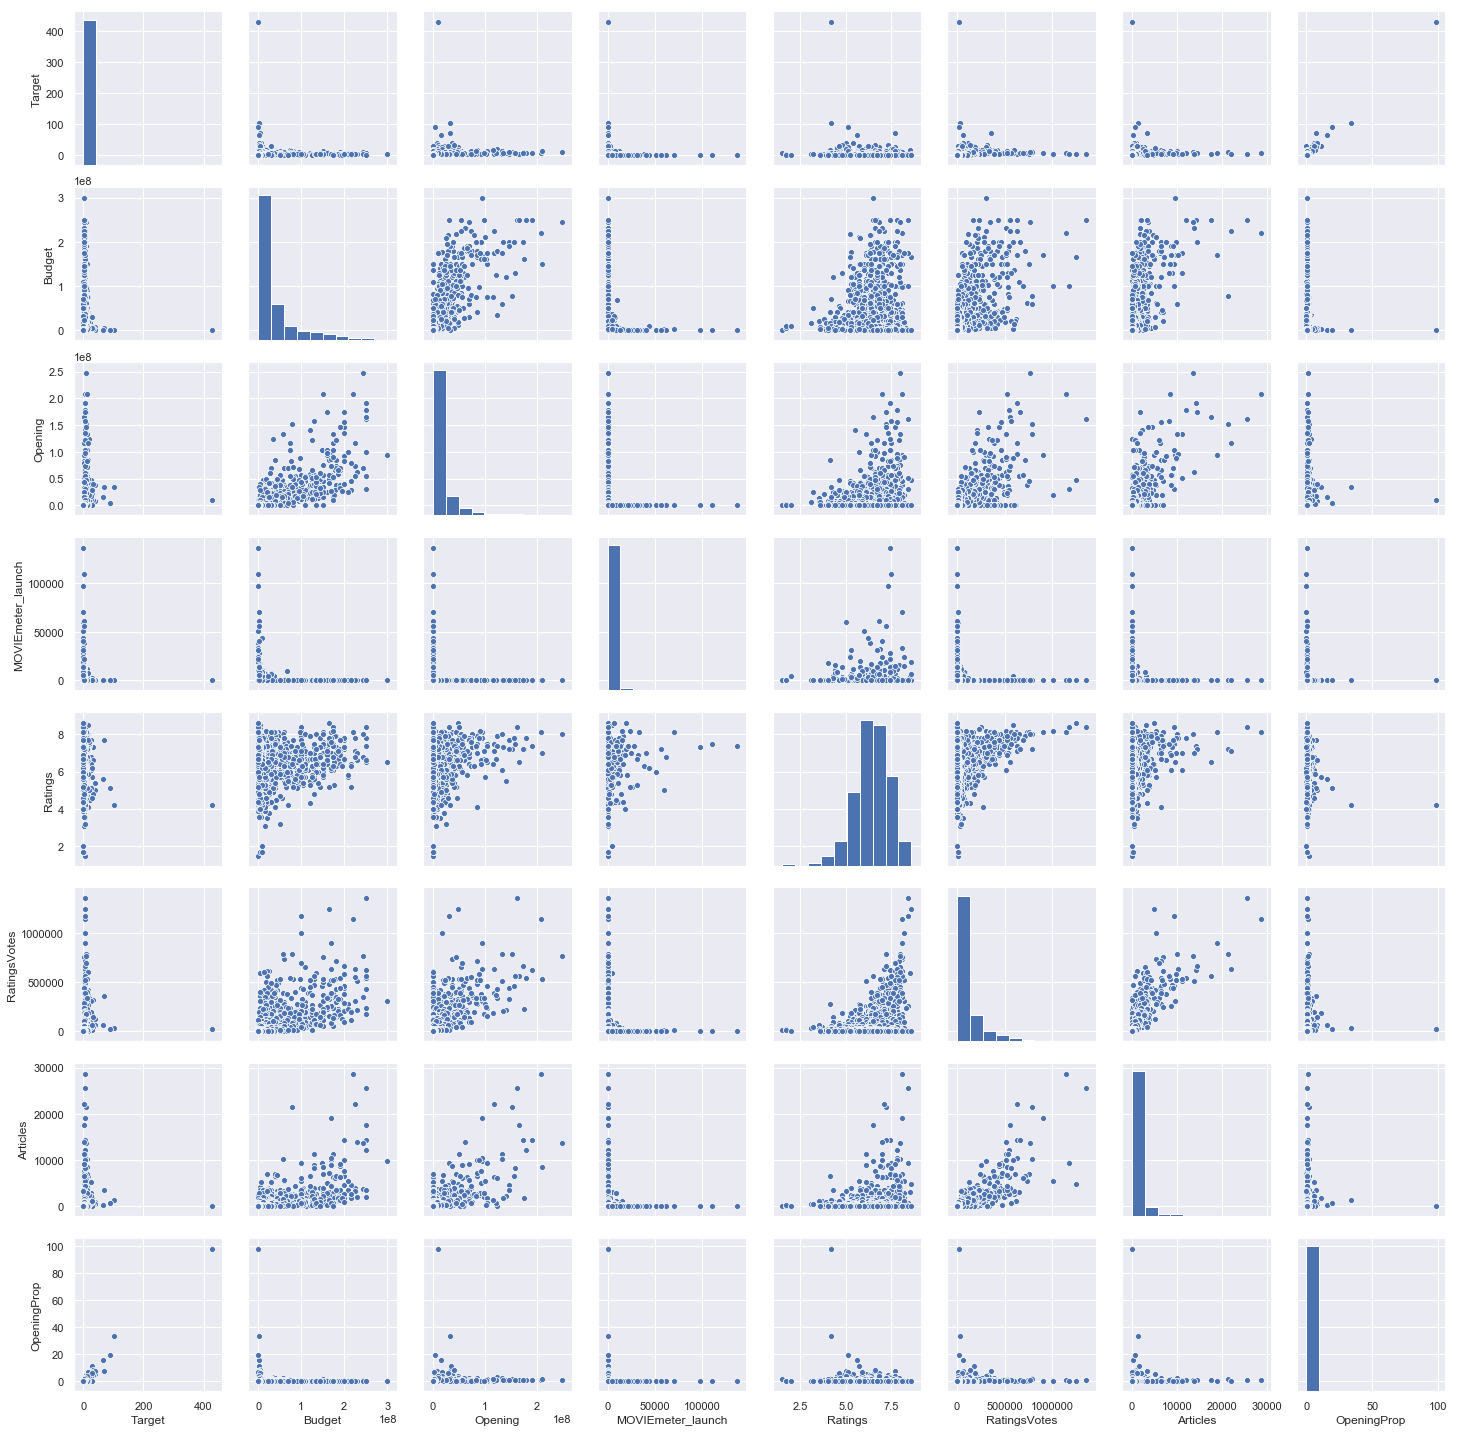

In [38]:
# Pairplot to see relationships
sns.pairplot(data=scrapedFilms_features)

- The above is not very useful. The relationships aren't clear at all for the most part. 
- This is likely due to the difference in scale between a number of the features, especially between Budget and Opening Weekend on the high side and Target and Opening Proportion on the low side. 
- We can take the log of these values to bring them closer together and see the relationships better. 

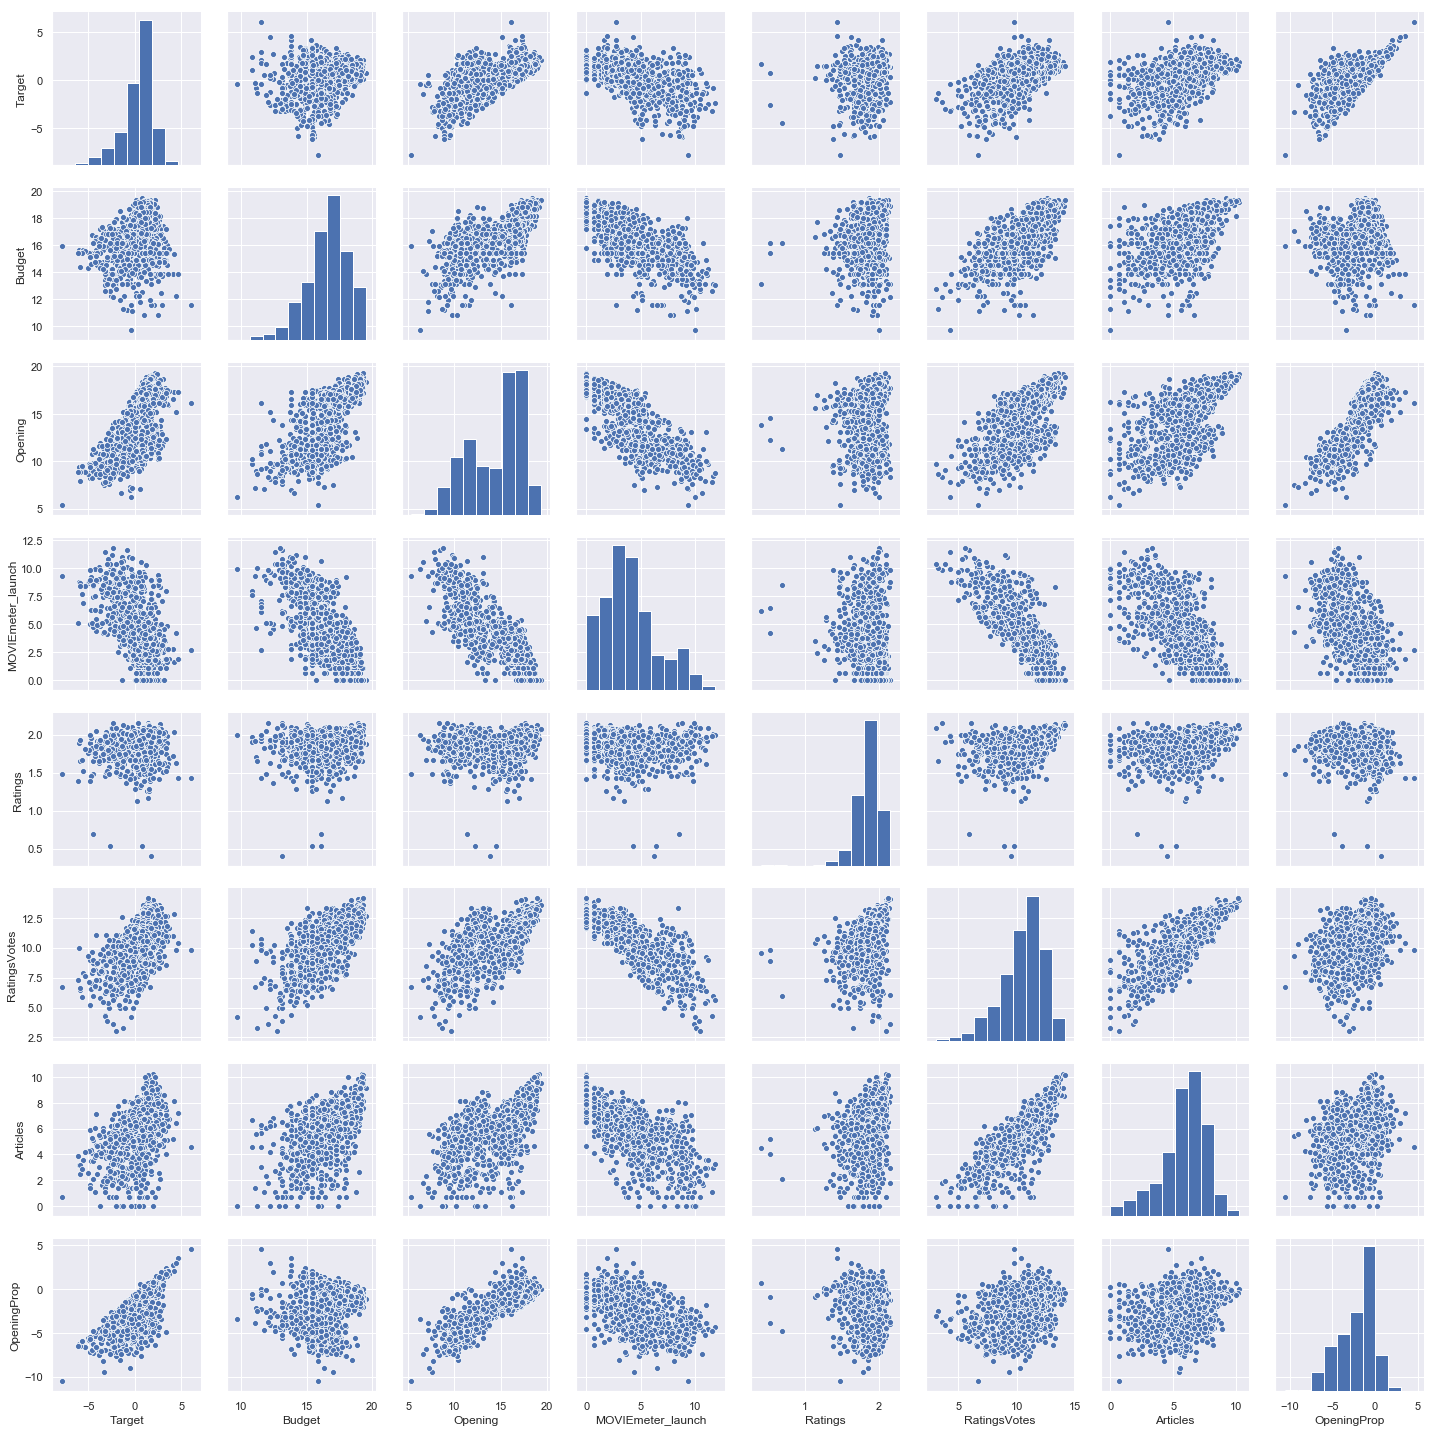

In [36]:
# Pairplot with log take of each feature
sns.pairplot(data=np.log(scrapedFilms_features))

- The above is a much more useful pair plot. There are definite correlation batterns and better candidates for deeper exploration.
- Not too many strange plots, but there are definitely some that strongly imply there is little correlation.
- Plots showing promising correlations:
    - Target/OpeningProp
    - Target/RatingsProp
    - Target/Opening
    - RatingsVotes/MOVIEmeter_launch
    - Budget/RatingsVotes
    - Opening/OpeningProp
    - Budget/MOVIEmeter_launch
    - Articles/RatingsVotes

## Explore possible relationships in greater detail

### Target & Opening Proportion of Budget

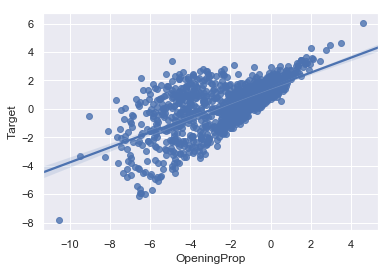

In [47]:
# Linear model plot of Target and OpeningProp
sns.regplot(x='OpeningProp', y='Target', data= np.log(scrapedFilms_features))

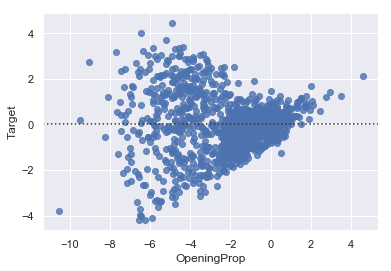

In [48]:
# Residuals plot
sns.residplot(x='OpeningProp', y='Target', data=np.log(scrapedFilms_features))

- Looks like some heteroscedasticity. 

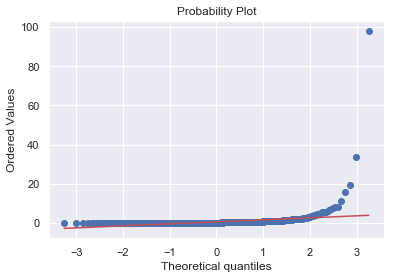

In [51]:
# Q-Q Plot of OpeningProp to see what the distribution looks like
x = np.array(scrapedFilms_features['OpeningProp'])
stats.probplot(x, dist="norm", plot=pylab)
pylab.show()

- Normal until we get to the right side then get some heavy right skew. 

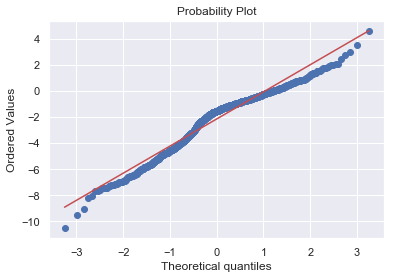

In [63]:
# Q-Q Plot of OpeningProp with log transform
x = np.array(np.log(scrapedFilms_features)['OpeningProp'])
stats.probplot(x, dist="norm", plot=pylab)
pylab.show()

- Though this is not an ideal distribution let's keep it for now and continue exploring the data.

__MOVIEmeter_launch & Target__

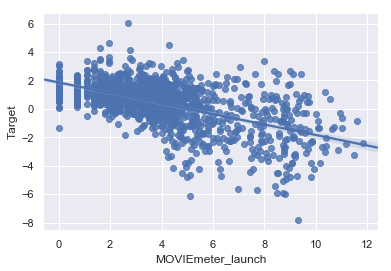

In [77]:
# Basic regression plot of log transformed MOVIEmeter_launch and Target
sns.regplot(x='MOVIEmeter_launch', y='Target', data=np.log(scrapedFilms_features))

- Looks like there's some relationship here. 

### Create log transformed version DF

In [72]:
# Create log transformed version of the df to save some typing.
scrapedFilms_log = np.log(scrapedFilms_features)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


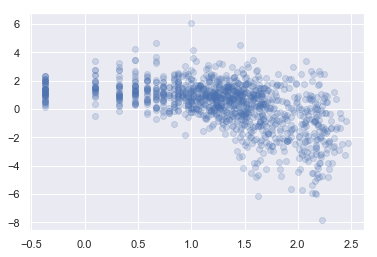

In [73]:
plt.scatter(np.log(scrapedFilms_log['MOVIEmeter_launch']), scrapedFilms_log['Target'], alpha = 0.2 )

- The scatterplot above seems to be a bit more truthful. There seems to be a light negative correlation if any at all.

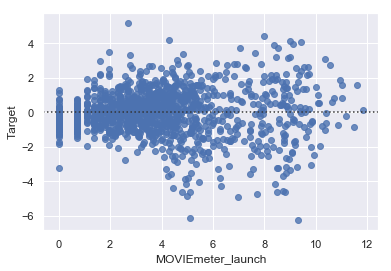

In [76]:
sns.residplot(x='MOVIEmeter_launch', y='Target', data=scrapedFilms_log)

- These residuals imply both some kind of relationship, but also heteroscedasticity. 

#### MOVIEmeter_launch & RatingsVotes
- These two features looked, at least visually on the pairplot, like they may have some relationship.

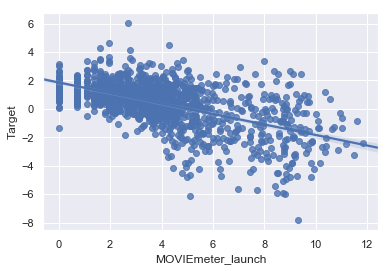

In [79]:
# Regression plot of log transformed MOVIEmeter_launch and RatingsVotes
sns.regplot(x='MOVIEmeter_launch', y='Target', data=np.log(scrapedFilms_features))

- There seems to be a bit of a pattern forming with these relationships. Many of these plots look very similar. 
- Let's start modeling and see what features seem to be the most important. 

## Ordinary Least Squares Regression

In [84]:
X = scrapedFilms_log.drop(['Target'], axis=1)
y = scrapedFilms_log['Target']

# fit model 
films_model = sm.OLS(y, X, data=scrapedFilms_log)

results = films_model.fit()

# statsmodel summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     369.2
Date:                Sun, 27 Jan 2019   Prob (F-statistic):          2.14e-269
Time:                        22:19:14   Log-Likelihood:                -1734.7
No. Observations:                1218   AIC:                             3481.
Df Residuals:                    1212   BIC:                             3512.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Budget               -0.3093      0.013    -24.030      0.000      -0.335      -0.284
Opening               0.0450      0.009      5.200      0.000       0.028       0.062
MOVIEmeter_launch    -0.0492      0.019     -2.599      0.009      -0.086      -0.012
Ratings               0.5201      0.186      2.799      0.005       0.156       0.885
RatingsVotes          0.5185      0.037     14.146      0.000       0.447       0.590
Articles             -0.1019      0.027     -3.714      0.000      -0.156      -0.048
OpeningProp           0.3543      0.012     29.189      0.000       0.330       0.378
==============================================================================
Omnibus:                       96.806   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              408.252
Skew:                           0.244   Prob(JB):                     2.23e-89
Kurtosis:                       5.794   Cond. No.                     1.07e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.05e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

- With the OLS above we see some definite correlations in the coefficients Budget, Opening, Ratings, RatingsVotes and OpeningProp. Let's keep these in mind moving forward.
- The $R^{2}$ value is ok at 0.646, but it's encouraging that the Adjusted $R^{2}$ is almost identical, 0.645.
- The Prob (F-statistic) is insanely low, so it seems very unlikely that these results are by chance. 
- Let's move on to some other techniques to see what their results are in terms of both feature selection and model performance. 

## Regular Split and Validate
- We'll use the split and validate code from the notebooks and lecture. 

In [103]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    # randomly take 20% our data and put into a test set 'test_size=0.2'
    # we want the training set to be much larger than the test set (here 80%) as it will lead to better modeling
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 
    
    

In [104]:
# Set target and feature values
X = scrapedFilms_features[['Budget', 'Opening', 'MOVIEmeter_launch', 'Ratings', 'RatingsVotes', 'Articles', 'OpeningProp']]
y = scrapedFilms_features['Target']

split_and_validate(X,y)


Validation R^2 score was: 0.6958780022993133
Feature coefficient results: 

Budget : -0.00
Opening : -0.00
MOVIEmeter_launch : -0.00
Ratings : 0.72
RatingsVotes : 0.00
Articles : -0.00
OpeningProp : 4.22


- The $R^{2}$ is decent, but with this method we are only left with two features of note, Ratings and OpeningProp, which seems quite odd.
- Let's try with only those two features in play. 

In [105]:
# Set target and feature values
X = scrapedFilms_features[['Ratings','OpeningProp']]
y = scrapedFilms_features['Target']

split_and_validate(X,y)


Validation R^2 score was: 0.6801483179097738
Feature coefficient results: 

Ratings : 0.99
OpeningProp : 4.23


- Slighly worse $R^{2}$, but about the same. Let's try other methods. 

## Regularized Linear Regression: LASSO and Ridge Regularization

In [117]:
# Set target and features
X, y = scrapedFilms_features.drop('Target',axis=1), scrapedFilms_features['Target']

In [118]:
#Split the data 60 - 20 - 20 train/val/test

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

- Let's find the right alpha by plotting the Mean Absolute Error.

In [119]:
#Mean Absolute Error (MAE) function
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 


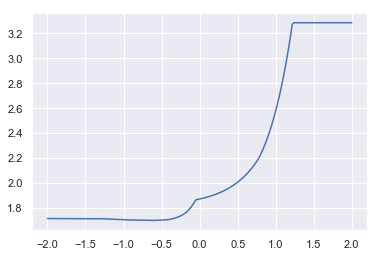

In [120]:
# Plot MAE
selected_columns = X.columns

alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.loc[:,selected_columns].values, y_train)
    
    val_set_pred = pipe.predict(X_val.loc[:,selected_columns].values)
    err_vec_val[i] = mae(y_val, val_set_pred)

plt.plot(np.log10(alphalist), err_vec_val)

In [121]:
# Value of the alpha that gives the lowest error
alphalist[np.argmin(err_vec_val)]

0.23272024789604084

- Utilize the alpha above in the LASSO regularization.

In [122]:
# Columns to use
selected_columns = X.columns

lasso_model = Lasso(alpha = 0.2) 
lasso_model.fit(X_train.loc[:,selected_columns], y_train)

Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [123]:
# Check coefficients with very high alpha model of LASSO
list(zip(selected_columns, lasso_model.coef_))

[('Budget', -8.41877069430813e-10),
 ('Opening', -1.0694637944873472e-08),
 ('MOVIEmeter_launch', -1.230319138341884e-05),
 ('Ratings', 0.453348380935677),
 ('RatingsVotes', 7.251349057920073e-06),
 ('Articles', -0.00010612281738249437),
 ('OpeningProp', 4.190585483933091)]

- All coefficients have values here, suggesting that they all contribute positively to the model. 

In [124]:
# Print out R2 Score for validation set
print("Lasso model validation R2:", lasso_model.score(X_val, y_val))

Lasso model validation R2: 0.7956056587184231


- This is an improved $R^{2}$ score over the previous OLS model and simple Train/Validate/Test approach. 
- Now let's move on to trying Cross-Validation. 

## Automated Regularization Strength with Cross-validation

In [126]:
# Set target and features
X = scrapedFilms_features[['Budget', 'Opening', 'MOVIEmeter_launch', 'Ratings', 'RatingsVotes', 'Articles', 'OpeningProp']]
y = scrapedFilms_features['Target']

#Split the data 60 - 20 - 20 train/val/test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

### Utilize the Standard Scaler

In [134]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train.values)

## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [135]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

lasso_model.alpha_

0.01

In [136]:
# Fit the LASSO model on this data using the new alpha of 0.01

In [137]:
## Fit a LASSO model on the standardized data using this alpha value
lasso_model = Lasso(alpha = 0.01)
lasso_model.fit(X_tr,y_train)
list(zip(X_train.columns, lasso_model.coef_))

[('Budget', -0.01165584614143749),
 ('Opening', -0.26592440865216416),
 ('MOVIEmeter_launch', -0.11505732276628632),
 ('Ratings', 0.7239946916043363),
 ('RatingsVotes', 0.8270839841887123),
 ('Articles', -0.14983468788596552),
 ('OpeningProp', 16.680420402788172)]

- __With this new alpha value, all features are non-zero so we should keep them all.__

### And finally test the data versus the LASSO CV model above

In [138]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [139]:
r2_score(y_test, test_set_pred)

0.6951602773950667

### For comparison we can try the Ridge CV model as well

In [140]:
ridgeCV_model = RidgeCV(alphas = alphavec, cv=5)
ridgeCV_model.fit(X_tr, y_train)

ridgeCV_model.alpha_

0.01

In [141]:
test_set_pred = ridgeCV_model.predict(X_te)

In [142]:
r2_score(y_test, test_set_pred)

0.6960749988309967

## CONCLUSIONS

- While the non-cross validated LASSO approach yielded the best $R^2$ score of 0.7956, the cross-validated methods tend to be the more reliable approach, so I would be more confident going with them. 
- Between Ridge CV (0.6961) and LASSO CV (0.6952) however the scores we're extremely similar. Ridge was slightly higher than LASSO, but from what I have read LASSO is better overall with smaller feature sets, so at this point I would go with LASSO.
- Overall however, I would like more time to explore this data, along with more deeply exploring the modeling techniques as well as testing additional features to improve confidence that I'm creating the best model. 